# The exemplification API example

This notebook shows a working example of exposing the optimization-based exemplification engine as a single python function call.

I deliverately define the `exemplify` function in a notebook, so that you can easily try and adjust it for your needs.
If you are happy with the result, copy and paste it into your codebase with its dependencies.

Minimal dependencies:
- Python 3.8
- Code under `src/`.
- Public Python packages: numpy, scipy, cmaes
- Private Python package `signal-temporal-logic` v0.2.1 with the `parser` feature enabled.
    - Just type `pip install signal-temporal-logic[parser] @ git+https://github.com/ERATOMMSD/signal-temporal-logic@v0.2.1` to install via git
    - Or you may find compiled wheels in <https://github.com/ERATOMMSD/signal-temporal-logic/releases>

In [6]:
%pip install -qq numpy scipy cmaes matplotlib
%pip install -qq "signal-temporal-logic[parser] @ git+https://github.com/ERATOMMSD/signal-temporal-logic@v0.2.1"

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Example spec to exemplify

carx = "x' > 5 /\ x' < 27 /\ x'' > -3 /\ x'' < 3 /\ x''' > -5 /\ x''' < 5"
cary = "y' > 5 /\ y' < 27 /\ y'' > -3 /\ y'' < 3 /\ y''' > -5 /\ y''' < 5"

sim_spec = f"x == 0 /\ y == 45 /\ F[0, 7](y - x < 10) /\ G({carx} /\ {cary} /\ y - x > 0)"
default_assumption_spec = "True"

# Example input signal configuration

input_variables = [
    dict(variable_name="x", max_derivative_order=3, n_control_points=5),
    dict(variable_name="y", max_derivative_order=3, n_control_points=5),
]

In [3]:
# Define exemplifying function and call it

from src.falsifier import Falsifier
from src.signal_processing import VariableConfig, SignalGenerator
import signal_tl.parser as parser
import numpy as np

def exemplify(
    spec: str,
    assumption: str, # The assumption formula. Give a str 'True' if no assumption.
    variables: 'list[VariableConfig]',
    start_time: float,
    end_time: float,
    time_step: float = 0.1,
    timeout_sec: float = 10.0,
) -> 'dict | None':
    """Search for a trace that satisfies the spec and assumption.
    The signals are generated by numerical optimization.

    Returns:
        None if no solution is found. Otherwise, a dictionary, containing the signals and the robustness value.
    """

    sampling_points = np.arange(
        start_time, end_time, time_step, dtype=float
    )

    # A mapping from a sampled point to input signals
    input_gen = SignalGenerator(variables, sampling_points)

    # Search
    falsifier = Falsifier(
        spec=parser.get_stl_ast(f'not ({spec})'), # satisfaction -> falsification
        assumption=parser.get_stl_ast(assumption),
        input_signal_generator=input_gen,
        model=lambda x: x,  # Identity model
        search_dim=input_gen.n_all_control_points,
        seed=None,
        timeout_sec=timeout_sec,
    )

    while not falsifier.should_stop():
        run = falsifier.ask_for_solution()
        if run is not None:  # Tell only if the run is valid
            falsifier.tell(run)

    if len(falsifier.falsified_solutions) == 0:
        return None
    else:
        return falsifier.falsified_solutions[0].to_dict()

########## Call the function ##########

result = exemplify(
    spec=sim_spec,
    assumption=default_assumption_spec,
    variables=[VariableConfig(**v) for v in input_variables],
    start_time=0.0,
    end_time=10.0,
    time_step=0.1,
    timeout_sec=10.0,
)

if result is not None:
    print(result['robustness'])
else:
    print("No solution found.")

-2.3854607334783395e-05


In [4]:
# JSON dump
import json

class NdarrayEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

json.dumps(result['trace'], cls=NdarrayEncoder)

'{"x": {"times": [0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9, 1.0, 1.1, 1.2000000000000002, 1.3, 1.4000000000000001, 1.5, 1.6, 1.7000000000000002, 1.8, 1.9000000000000001, 2.0, 2.1, 2.2, 2.3000000000000003, 2.4000000000000004, 2.5, 2.6, 2.7, 2.8000000000000003, 2.9000000000000004, 3.0, 3.1, 3.2, 3.3000000000000003, 3.4000000000000004, 3.5, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.0, 4.1000000000000005, 4.2, 4.3, 4.4, 4.5, 4.6000000000000005, 4.7, 4.800000000000001, 4.9, 5.0, 5.1000000000000005, 5.2, 5.300000000000001, 5.4, 5.5, 5.6000000000000005, 5.7, 5.800000000000001, 5.9, 6.0, 6.1000000000000005, 6.2, 6.300000000000001, 6.4, 6.5, 6.6000000000000005, 6.7, 6.800000000000001, 6.9, 7.0, 7.1000000000000005, 7.2, 7.300000000000001, 7.4, 7.5, 7.6000000000000005, 7.7, 7.800000000000001, 7.9, 8.0, 8.1, 8.200000000000001, 8.3, 8.4, 8.5, 8.6, 8.700000000000001, 8.8, 8.9, 9.0, 9.1, 9.200000000000001, 9.3, 9.4, 9.5, 9.60000000000000

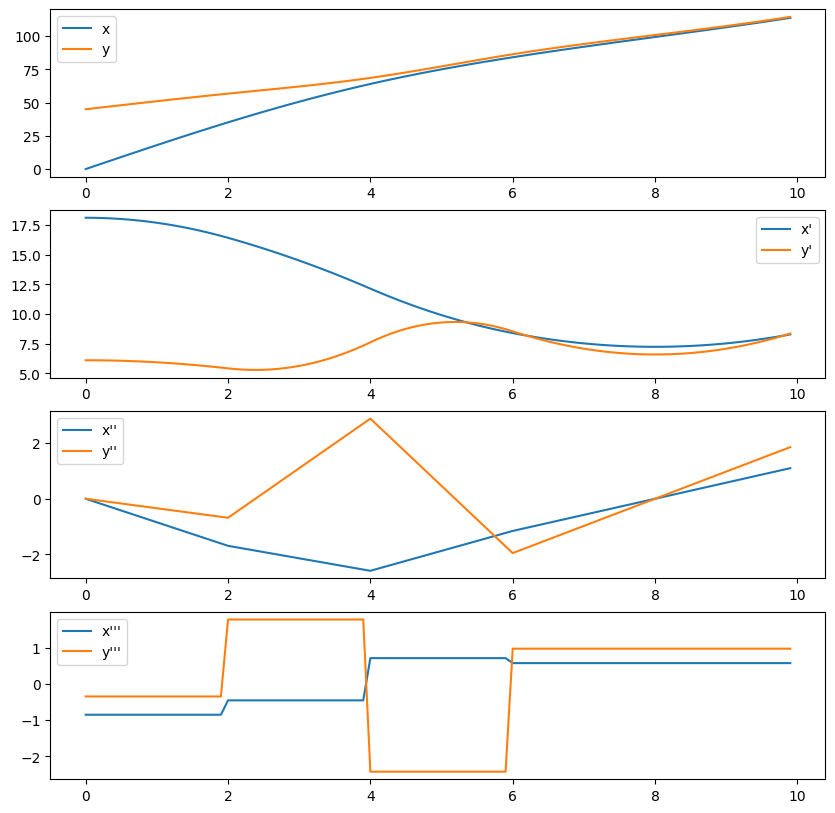

In [5]:
# Visualize the result

import matplotlib.pyplot as plt

fig, ax = plt.subplots(4, 1, figsize=(10, 10))

for i in range(4):
    prime = "'" * i
    for var in ["x" + prime, "y" + prime]:
        sig = result['trace'][var]
        ax[i].plot(sig['times'], sig['values'], label=var)
    ax[i].legend()